In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
import tensorflow_decision_forests as tfdf

import lbg_forecast.noise as noise
import lbg_forecast.colour_cuts as cuts

import optimise_stellar as stellar

In [2]:
def build_redshift_distribution_samples_object(u_data, g_data, r_data):

    u_redshifts = cuts.get_zs(u_data)
    g_redshifts = cuts.get_zs(g_data)
    r_redshifts = cuts.get_zs(r_data)

    redshift_array = np.empty(3, object)
    redshift_array[:] = [u_redshifts, g_redshifts, r_redshifts]     

    return redshift_array

def generate_training_data_labels(redshifts, zmin, zmax):
    '''
    dropout between zmin=zmax -> label=1; else=0
    '''

    labels = np.zeros_like(redshifts)
    u_indexes = np.where((redshifts > zmin) & (redshifts < zmax) )[0]#& (data[:, 0] - data[:, 1] > 0.0))[0]
    labels[u_indexes] = 1

    return labels

def create_test_validation_data(data, labels, validation_split, batch_size):
    """turns output of prepare data into tensorflow dataset, given test/training
    split and batch size
    """
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    validation_split = validation_split
    train_size = int(validation_split * data.shape[0])
    test_size = data.shape[0] - train_size

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)

    train_dataset = train_dataset.batch(batch_size=batch_size)
    test_dataset = test_dataset.batch(batch_size=batch_size)

    return train_dataset, test_dataset, train_size, test_size

def make_prediction(model, dataset):
    """return predicted labels (between 0 and 1) for
    a given tensorflow dataset
    """
    labels = model.predict(dataset)
    return labels[:, 0]

def make_prediction_at_confidence(model, dataset, confidence_level):
    """return predicted labels (0 or 1) for
    a given tensorflow dataset, for given a confidence level
    """
    labels = make_prediction(model, dataset)
    predicted_labels_at_confidence = np.where(labels > confidence_level, 1.0, 0.0)
    return predicted_labels_at_confidence

def get_optimised_nz(model, dataset, redshifts, confidence_level):
    predicted_labels = make_prediction_at_confidence(model, dataset, confidence_level)
    selected = redshifts[np.where(predicted_labels == 1.0)[0]]
    return selected

def get_binned_nz(redshifts):
    binned = redshifts[np.where((redshifts > 2.5) & (redshifts < 3.5) )[0]]
    return binned

def get_interlopers(redshifts):
    interlopers = redshifts[np.where(redshifts < 1.5)[0]]
    return interlopers

def confusion_matrix(original_labels, predicted_labels):
    cmatrix = tf.math.confusion_matrix(original_labels, predicted_labels)
    print(cmatrix)
    # TN FP
    # FN TP
    return cmatrix

def evaluate_model_performance(model, dataset, redshifts, original_labels, confidence_level):

    cmatrix = confusion_matrix(original_labels, make_prediction_at_confidence(model, dataset, confidence_level))
    selected_objects = get_optimised_nz(model, dataset, redshifts, confidence_level)
    original_objects = get_binned_nz(redshifts)
    ninterlopers =  get_interlopers(selected_objects).shape[0]

    print("efficency(%): ", float(((cmatrix[1, 1])/original_objects.shape[0])*100))
    print("purity(%): ", float((cmatrix[1, 1]/(cmatrix[0,1]+cmatrix[1, 1]))*100)) #of all positives - which are truly lbgs?
    print("interloper fraction(%): ", (ninterlopers/selected_objects.shape[0])*100) 

(200000, 17) (200000, 5) (200000, 4) mean redshift: 3.493885761907365


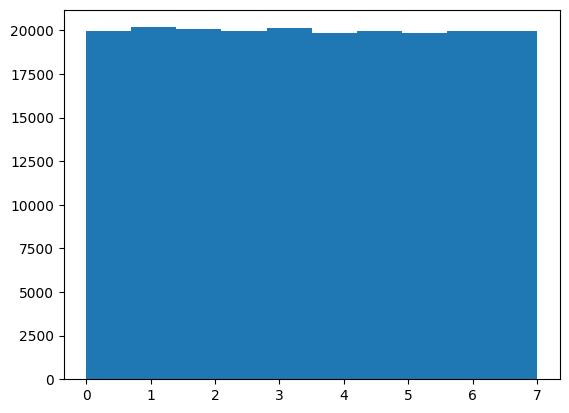

In [3]:
size=200000
train_sps = np.load('validation_data/sps_parameters_1200000.npy')[:size, :]
train_phot = np.load('validation_data/photometry_1200000.npy')[:size, :-1] 
train_colours = cuts.calculate_colours(train_phot)
train_redshift = train_sps[:, 0]
print(train_sps.shape, train_phot.shape, train_colours.shape, 'mean redshift:' ,np.mean(train_redshift))
red_prior = plt.hist(train_redshift)

u_labels = generate_training_data_labels(train_redshift, 2.5, 3.5)
g_labels = generate_training_data_labels(train_redshift, 3.5, 4.5)
r_labels = generate_training_data_labels(train_redshift, 4.5, 5.5)

In [4]:
train_phot_noise = noise.setup_catalog(train_phot)
train_phot_noise = train_phot_noise.iloc[:, :5]
train_phot_noise = train_phot_noise.to_numpy()

train_colours_noise = cuts.calculate_colours(train_phot_noise)

print(train_phot_noise.shape, train_colours_noise.shape)

labels = u_labels

(200000, 5) (200000, 4)


In [5]:
train_dataset, test_dataset, train_size, test_size = create_test_validation_data(train_colours, labels, 0.9, batch_size=1000)

model = tfdf.keras.RandomForestModel(max_depth=32, verbose=2, task=tfdf.keras.Task.CLASSIFICATION)
model.fit(train_dataset)


model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_dataset, return_dict=True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")


Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpl34hhotk as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 4), dtype=float64)
Label: Tensor("data_1:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>)}
Training dataset read in 0:00:01.669581. Found 180000 examples.
Training model...
Standard output detected as not visible to the user e.g. run

20/20 [==============================] - 1s 41ms/step
tf.Tensor(
[[16792   342]
 [  725  2141]], shape=(2, 2), dtype=int32)
20/20 [==============================] - 1s 40ms/step
efficency(%):  74.70341939986044
purity(%):  86.22633910592026
interloper fraction(%):  2.174788562223117


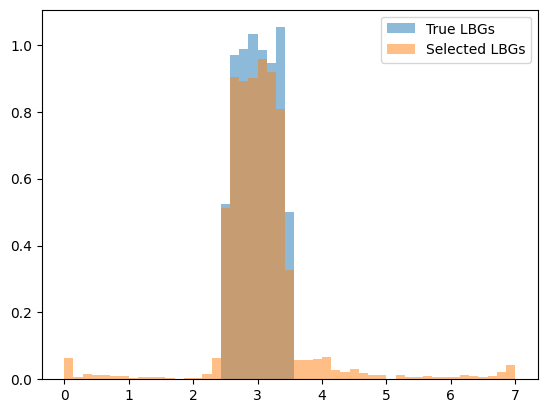

In [6]:
z_bins = np.linspace(0.0, 7.0, 50)
confidence = 0.5
original_objects = get_binned_nz(train_redshift[train_size:])
selected_objects = get_optimised_nz(model, test_dataset, train_redshift[train_size:], confidence)
plt.hist(original_objects, density=True, label="True LBGs", bins=z_bins, alpha=0.5)
plt.hist(selected_objects, density=True, label="Selected LBGs", bins=z_bins, alpha=0.5)
plt.legend()
selected_objects.shape[0]
evaluate_model_performance(model, test_dataset, train_redshift[train_size:], labels[train_size:], confidence)

In [7]:
#apply noise, the perform SNR, brightness and faintness cuts
all_dropouts_mags = noise.get_noisy_magnitudes(train_sps, train_phot)

#convert magnitudes to colours
all_dropouts_colours = cuts.colours(all_dropouts_mags)

#apply LBG colour cuts
u_data, g_data, r_data = cuts.apply_cuts_to_colours(all_dropouts_colours)

#get selected redshift samples and combine into object array
nzs = build_redshift_distribution_samples_object(u_data, g_data, r_data)

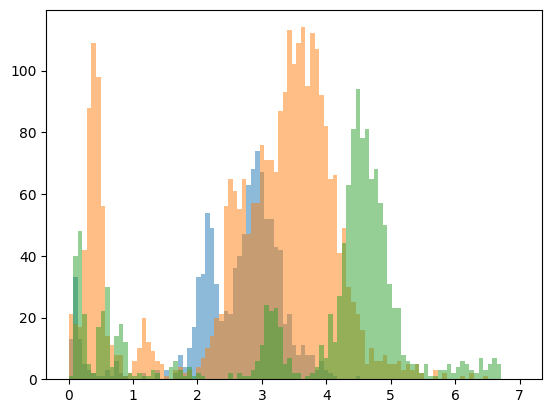

In [8]:
bins = np.linspace(0, 7, 100)
alpha=0.5
u_nz = plt.hist(nzs[0], bins=bins, alpha=alpha)
g_nz = plt.hist(nzs[1], bins=bins, alpha=alpha)
r_nz = plt.hist(nzs[2], bins=bins, alpha=alpha)

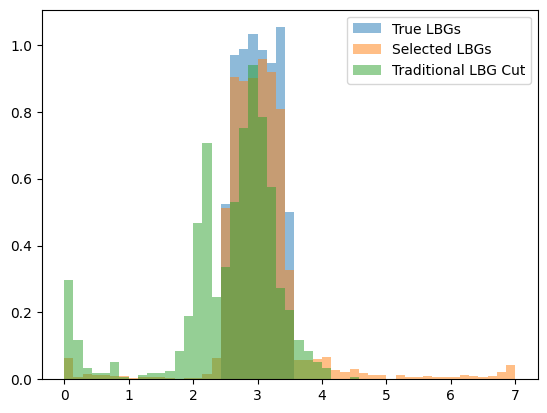

In [9]:
plt.hist(original_objects, density=True, label="True LBGs", bins=z_bins, alpha=0.5)
plt.hist(selected_objects, density=True, label="Selected LBGs", bins=z_bins, alpha=0.5)
plt.hist(nzs[0], bins=z_bins, label="Traditional LBG Cut", density=True, alpha=0.5)
plt.legend()

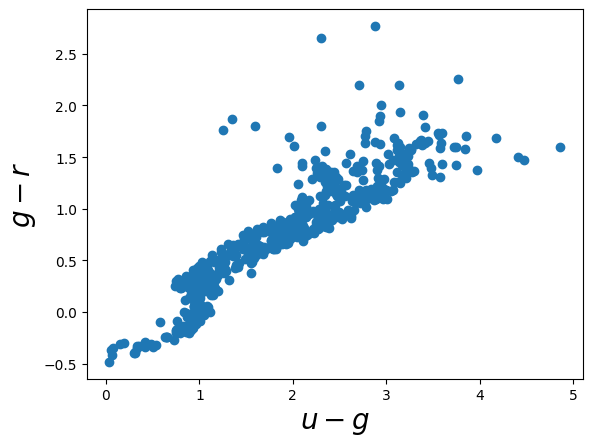

In [10]:
xsl_colours = stellar.get_xsl_LSST_colours()
xsl_labels = np.zeros(xsl_colours.shape[0])
stellar.plot_xsl_colour_diagram()

In [12]:
confidence = 0.5
train_dataset, test_dataset, train_size, test_size = create_test_validation_data(xsl_colours, xsl_labels, 1.0, 1000)
classification = make_prediction_at_confidence(model, train_dataset, confidence)
print("Stars Wrongly Classified as Galaxies(%): ", ((np.where(classification > 0.0)[0]).shape[0]/xsl_labels.shape[0])*100)

1/1 [==============================] - 0s 57ms/step
Stars Wrongly Classified as Galaxies(%):  37.954939341421145
